## Transformers Explained Step by Step:
### I. Introduction
    - Tokenization
    - Embedding
    - Self-Attention Mechanism
    - Keys, Queries, and Values
    - Multi-head Attention
    
### II. Implementation
### III. Examples
    - Synthetic Data
    - Coastal Fog Forecasting
----------------------------------------------------------------------------------

## I. Introduction

In this section, we will: 
- learn the theoretical background on how transformers work and which are the basic components.
- code all the different blocks of transformers architecture from scratch using PyTorch. 


### 1. Transformers explained step by step


<figure>
    <p align="center">
        <img src="https://nlp.seas.harvard.edu/images/the-annotated-transformer_0_0.png" alt="Alt text for the image" width = "500px"/>
        <figcaption>Attention is All You Need. Figure Credit: <a href="https://nlp.seas.harvard.edu/2018/04/03/attention.html">Vaswani et al, 2017</a></figcaption>
    </p>
</figure>


<b><font size="4">What is Attention?</font></b>  
The Attention mechanism describes a weighted averages of (sequence) elements with the <b>weights dynamically</b> computed based on an input query and elements' keys.



This is the diagram of the Transformers network presented in the `Attention is All You Need` paper. We will go through all the differet pieces of this network throughout this notebook. 


<figure>
    <p align="center">
        <img src="https://www.researchgate.net/publication/344197785/figure/fig2/AS:934416989843456@1599793779015/Transformer-model-architecture-described-in-Attention-Is-All-You-Need-6.ppm" alt="Alt text for the image" width = "500px"/>
        <figcaption>Transformers Architecture. Figure Credit: <a href="https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf">Vaswani et al, 2017</a></figcaption>
    </p>
</figure>


#### Tokenization 
Tokenization is the the first step in processing input data, including text, audio, image, video or 4D environmental data. <br> In processing text each token correspond roughly to words and punctuation, although a word can also be split into several tokens. <br> In processing image it can small patch of image, etc. 


<figure>
    <p align="center">
        <img src="https://i.imgur.com/kCoLZuG.png" alt="Alt text for the image"/>
        <figcaption>Word Tokenizer. Figure Credit: <a href="https://www.kaggle.com/code/alejopaullier/introduction-to-transformers">link</a></figcaption>
    </p>
</figure>

#### Embedding 
The Second step is to associate each token with an <b> embedding </b>, which is nothing more than a vector of real numbers. 

<figure>
    <p align="center">
        <img src="https://i.imgur.com/NulRCFU.png" alt="Alt text for the image"/>
        <figcaption>Embedding. Figure Credit: <a href="https://www.kaggle.com/code/alejopaullier/introduction-to-transformers">Link</a></figcaption>
    </p>
</figure>

- The values inside an embedding carry information about the meaning of the token, but they are also arranged in such a way that one can perform mathematical operations on them, which correspond to semantic changes.
- Embedding are associated with tokens, which means that the same token always gets the same embedding, regardless of its context. 

#### Image Embedding
<figure>
    <p align="center">
        <img src="https://media.giphy.com/media/ATsWtUsuuFRfq8OhZ7/source.gif" alt="Alt text for the image"/>
        <figcaption>Vision Transformers [image embedding]. Figure Credit: <a href="https://theaisummer.com/hugging-face-vit/">Link</a></figcaption>
    </p>
</figure>

### Self-Attention 
Self-attention is the center of Attention mechanism, which in particular it has four parts: 
- <b>Query</b>: The quary is a feature vector describes what are looking for in the sequence, i,e. what would we maybe to <b>pay attention to</b>.
- <b>Keys</b>: For each each input element, we have a key which is roughly describes what the elements is <b>offering</b>. 
- <b>Values</b>: This feature vector is the one we want to <b>average over</b>.
- <b>Score function</b>: To rate input elements we want to pay attention to, we need to specify a <b>score function</b>. The score function takes the query and a key as input, output the score/attention weight of the query-key pair. It is usually implemented by simple similarity matrices like a <b> dot product</b>. 


Query, keys and values are weights matrices, which are adjusted as a model parameters during training. 


<figure>
    <p align="center">
        <img src="https://i.imgur.com/lIhueb8.png" alt="Alt text for the image"/>
        <figcaption>Self-Attention. Figure Credit: <a href="https://www.kaggle.com/code/alejopaullier/introduction-to-transformers">Link</a></figcaption>
    </p>
</figure>

##### Scaled dot-product

<figure>
    <p align="center">
        <img src="https://i.imgur.com/qfFLyND.gif" alt="Alt text for the image"/>
        <figcaption>scaled dot-product. Figure Credit: <a href="https://www.kaggle.com/code/alejopaullier/introduction-to-transformers">Link</a></figcaption>
    </p>
</figure>

### Multi-Head Attention
In addition, the same process can be repeated many times with different Key, Query, and Value projections, forming what is called a multi-head attention.

<figure>
    <p align="center">
        <img src="https://i.imgur.com/pH4NcnC.png" alt="Alt text for the image"/>
        <figcaption>Multi-Head Attention. Figure Credit: <a href="https://www.kaggle.com/code/alejopaullier/introduction-to-transformers">Link</a></figcaption>
    </p>
</figure>


## II. Implementation (Pytorch)

#### 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import time 
import torch.optim as optim
import math
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 2. MultiHead Attention

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        """
        Initializes the MultiHeadAttention module. This module is a key component in Transformer architectures,
        allowing the model to jointly attend to information from different representation subspaces.

        Args:
        embed_size (int): Size of the input embeddings.
        heads (int): Number of attention heads.

        The embeddings are split into 'heads' number of chunks, and each chunk is processed by a different attention mechanism.
        """
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size # Typically 512 in a Transformer model.
        self.heads = heads # Number of attention heads, usually 8.
        self.head_dim = embed_size // heads # Dimension of each head, e.g., 64.

        # Ensure that the embedding size is divisible by the number of heads.
        assert (
            self.head_dim * self.heads == embed_size
        ), "Embedding size must be divisible by the number of heads."

        # Linear layers to project the input embeddings into Query, Key, and Value spaces.
        # We project embeddings to the same size and then split them into different heads.
        self.values = nn.Linear(embed_size, embed_size)
        self.keys = nn.Linear(embed_size, embed_size)
        self.queries = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size) # Final linear layer.

    def forward(self, values, keys, query, mask):
        """
        Forward pass of the MultiHeadAttention layer.

        Args:
        values (Tensor): Value tensor.
        keys (Tensor): Key tensor.
        query (Tensor): Query tensor.
        mask (Tensor): Tensor to mask certain positions (e.g., for padding).

        Each of these tensors has the shape (batch_size, sequence_length, embedding_size).
        """
        batch_size = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Pass through the linear layers.
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)

        # Split the embeddings into 'heads' number of chunks.
        values = values.reshape(batch_size, value_len, self.heads, self.head_dim)
        keys = keys.reshape(batch_size, key_len, self.heads, self.head_dim)
        queries = queries.reshape(batch_size, query_len, self.heads, self.head_dim)

        # Calculate attention scores using matrix multiplication.
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        # Apply mask to the attention scores, if provided.
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Apply softmax to normalize the attention scores.
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        # Multiply attention scores with values and combine heads.
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            batch_size, query_len, self.heads * self.head_dim
        )

        # Final linear layer to produce the output.
        out = self.fc_out(out)
        return out




In [3]:
class Attention(nn.Module):

    def __init__(
            self,
            embed_size, heads
    ):
        super().__init__()
        self.embed_size = embed_size
        self.heads = heads
        qkv_bias = False,
        qk_norm  = False,

        assert self.embed_size % self.heads == 0, 'dim should be divisible by num_heads'
   
        self.head_dim = self.embed_size // self.heads
        self.scale = self.head_dim ** -0.5


        self.qkv = nn.Linear(self.embed_size, self.embed_size * 3, bias=qkv_bias)
        self.q_norm = nn.LayerNorm(self.head_dim) if qk_norm else nn.Identity()
        self.k_norm = nn.LayerNorm(self.head_dim) if qk_norm else nn.Identity()
        self.attn_drop = nn.Dropout(0.1)
        self.proj = nn.Linear(self.embed_size, self.embed_size)
        self.proj_drop = nn.Dropout(0.1)


    #     self._init_weights()

    # def _init_weights(self):
    #     nn.init.xavier_uniform_(self.proj.weight)
    #     nn.init.xavier_uniform_(self.qkv.weight)
    #     nn.init.normal_(self.proj.bias, std=1)
    #     nn.init.normal_(self.qkv.bias, std=1)


    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        q, k = self.q_norm(q), self.k_norm(k)


        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        weights = attn.softmax(dim=-1)
        attn = self.attn_drop(weights)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

#### Encoder Layer

<figure>
    <p align="center">
        <img src="https://i.imgur.com/vUOhpoC.png" alt="Alt text for the image"/>
        <figcaption>Encoder Layer. Figure Credit: <a href="https://www.kaggle.com/code/alejopaullier/introduction-to-transformers">Link</a></figcaption>
    </p>
</figure>



In [3]:
class TransformerLayer(nn.Module):
    def __init__(self, embed_size=512, heads=8, dropout=0.0, forward_expansion=4):
        """
        Initializes a Transformer Layer used in the Transformer model. This layer consists of a MultiHeadAttention mechanism,
        followed by layer normalization, a feed-forward network, and another layer normalization.

        Args:
        embed_size (int): Size of the embedding.
        heads (int): Number of attention heads.
        dropout (float): Dropout rate.
        forward_expansion (int): Expansion factor for the feed-forward network.
        """
        super(TransformerLayer, self).__init__()
        self.attention = MultiHeadAttention(embed_size, heads) # Multi-head attention mechanism.
        self.norm1 = nn.LayerNorm(embed_size) # Layer normalization.
        self.norm2 = nn.LayerNorm(embed_size) # Another layer normalization.
        
        # Feed-forward network.
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size), # Expands the embedding.
            nn.ReLU(), # Activation function.
            nn.Linear(forward_expansion * embed_size, embed_size), # Projects back to embedding size.
        )
        self.dropout = nn.Dropout(dropout) # Dropout layer.

    def forward(self, value, key, query, mask):
        """
        Forward pass of the Transformer Layer.

        Args:
        value (Tensor): Value tensor.
        key (Tensor): Key tensor.
        query (Tensor): Query tensor.
        mask (Tensor): Mask tensor for attention.

        Each tensor has the shape (batch_size, sequence_length, embedding_size).
        """
        # Apply the MultiHeadAttention mechanism.
        attention = self.attention(value, key, query, mask)

        # Apply the first layer normalization and dropout with skip connection.
        x = self.dropout(self.norm1(attention + query))

        # Pass through the feed-forward network.
        forward = self.feed_forward(x)

        # Apply the second layer normalization and dropout with skip connection.
        out = self.dropout(self.norm2(forward + x))

        return out


#### 3. Encoder 
<figure>
    <p align="center">
        <img src="https://i.imgur.com/rbEe0lW.png" alt="Alt text for the image"/>
        <figcaption>Encoder. Figure Credit: <a href="https://www.kaggle.com/code/alejopaullier/introduction-to-transformers">Link</a></figcaption>
    </p>
</figure>

In [4]:
class Encoder(nn.Module):
    def __init__(
        self, 
        embed_size: int, 
        num_layers: int, 
        heads: int,
        device: str, 
        forward_expansion: int, 
        dropout: float,
        src_vocab_size: int, 
        max_length: int
    ) -> None:
        """
        Initializes the Encoder part of the Transformer model. This encoder processes the input sequence
        using a series of Transformer layers.

        Args:
        embed_size (int): Size of the input embeddings.
        num_layers (int): Number of Transformer layers in the encoder.
        heads (int): Number of attention heads.
        device (str): Device to run the model on ('cuda' or 'cpu').
        forward_expansion (int): Expansion factor for the feed-forward network in Transformer layers.
        dropout (float): Dropout rate.
        src_vocab_size (int): Size of the source vocabulary.
        max_length (int): Maximum length of input sequences.
        """
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device

        # Embedding layer for input words.
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)

        # Positional embedding layer for word positions.
        self.position_embedding = nn.Embedding(max_length, embed_size)

        # Stack of Transformer layers.
        self.layers = nn.ModuleList(
            [TransformerLayer(embed_size, heads, dropout, forward_expansion) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        Forward pass through the encoder.

        Args:
        x (Tensor): Input sequence of word indices. Shape: (batch_size, sequence_length).
        mask (Tensor): Mask tensor to ignore certain positions (e.g., padding).

        Returns:
        Tensor: Output tensor after processing with Transformer layers. Shape: (batch_size, sequence_length, embed_size).
        """
        batch_size, seq_length = x.shape

        # Generate position indices and send to the same device as input.
        positions = torch.arange(0, seq_length).expand(batch_size, seq_length).to(self.device)

        # Combine word and position embeddings with dropout.
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

        # Pass through each Transformer layer.
        for layer in self.layers:
            out = layer(out, out, out, mask)  # In the encoder, Q, K, V are all the same.

        return out


#### 4. Decoder Layer 
<figure>
    <p align="center">
        <img src="https://i.imgur.com/yV18zvn.png" alt="Alt text for the image"/>
        <figcaption>Decoder Layer. Figure Credit: <a href="https://www.kaggle.com/code/alejopaullier/introduction-to-transformers">Link</a></figcaption>
    </p>
</figure>

In [5]:
class DecoderLayer(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        """
        Initializes a Decoder Layer used in the Transformer model. This layer consists of a MultiHeadAttention mechanism 
        focused on the target sequence, followed by another MultiHeadAttention mechanism that takes into account 
        the output of the encoder. Finally, it applies a feed-forward network.

        Args:
        embed_size (int): Size of the input embeddings.
        heads (int): Number of attention heads.
        forward_expansion (int): Expansion factor for the feed-forward network.
        dropout (float): Dropout rate.
        device (str): Device to run the model on ('cuda' or 'cpu').
        """
        super(DecoderLayer, self).__init__()
        self.norm = nn.LayerNorm(embed_size) # Layer normalization.
        self.attention = MultiHeadAttention(embed_size, heads=heads) # Self-attention for the decoder.
        
        # Transformer block (Self-attention + feed-forward).
        self.transformer_block = TransformerLayer(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout) # Dropout layer.

    def forward(self, x, value, key, src_mask, trg_mask):
        """
        Forward pass through the decoder layer.

        Args:
        x (Tensor): Target sequence input. Shape: (batch_size, target_sequence_length, embedding_size).
        value (Tensor): Value tensor from the encoder output.
        key (Tensor): Key tensor from the encoder output.
        src_mask (Tensor): Mask for source sequence to ignore padding.
        trg_mask (Tensor): Mask for target sequence for causal attention.

        Returns:
        Tensor: Output after processing with the decoder layer. Shape: (batch_size, target_sequence_length, embedding_size).
        """
        # Apply self-attention to the target sequence.
        attention = self.attention(x, x, x, trg_mask)

        # Combine the attention output with the original input and apply dropout and normalization.
        query = self.dropout(self.norm(attention + x))

        # Pass through the Transformer block with encoder's key and value.
        out = self.transformer_block(value, key, query, src_mask)
        
        return out


#### 5. Decoder

In [6]:
class Decoder(nn.Module):
    def __init__(self, embed_size, num_layers, heads, forward_expansion,
                 dropout, device, trg_vocab_size, max_length):
        """
        Initializes the Decoder part of the Transformer model. This decoder takes the output from the Transformer's encoder
        and generates the target sequence.

        Args:
        trg_vocab_size (int): Size of the target vocabulary.
        embed_size (int): Size of the embeddings.
        num_layers (int): Number of DecoderLayer modules in the Decoder.
        heads (int): Number of attention heads in each DecoderLayer.
        forward_expansion (int): Expansion factor for the feed-forward network in each DecoderLayer.
        dropout (float): Dropout rate.
        device (str): Device the model is running on ('cuda' or 'cpu').
        max_length (int): Maximum length of the target sequence.
        """
        super(Decoder, self).__init__()
        self.device = device

        # Embedding layers for the target words and their positions.
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        # Stack of DecoderLayer modules.
        self.layers = nn.ModuleList(
            [DecoderLayer(embed_size, heads, forward_expansion, dropout, device) for _ in range(num_layers)]
        )

        # Final linear layer to output probabilities over the target vocabulary.
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        """
        Forward pass through the decoder.

        Args:
        x (Tensor): Input sequence of target word indices. Shape: (batch_size, target_sequence_length).
        enc_out (Tensor): Output from the encoder. Shape: (batch_size, source_sequence_length, embedding_size).
        src_mask (Tensor): Mask for source sequence to ignore padding.
        trg_mask (Tensor): Mask for target sequence to allow causal (autoregressive) decoding.

        Returns:
        Tensor: Output tensor with logits for the next word prediction. Shape: (batch_size, target_sequence_length, trg_vocab_size).
        """
        batch_size, seq_length = x.shape

        # Generate position indices and send to the same device as input.
        positions = torch.arange(0, seq_length).expand(batch_size, seq_length).to(self.device)

        # Combine word and position embeddings with dropout.
        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

        # Pass through each DecoderLayer, using encoder output as key and value.
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)

        # Final linear layer to produce output logits.
        out = self.fc_out(x)

        return out


## III. Examples 

### A. Synthetic Data

In [7]:
class Text_Transformer(nn.Module):
    def __init__(self, 
                 src_vocab_size: int = 0, 
                 trg_vocab_size: int = 0, 
                 src_pad_idx: int = 10, 
                 trg_pad_idx: int = 10, 
                 embed_size: int = 512,
                 num_layers: int = 6, 
                 forward_expansion: int = 4, 
                 heads: int = 8, 
                 dropout: float = 0., 
                 device = "cpu", 
                 max_length: int =100):

        super(Text_Transformer, self).__init__()
        # === Encoder ===

        self.encoder = Encoder(embed_size = embed_size, 
                               num_layers = num_layers, 
                               heads = heads, 
                               device = device, 
                               forward_expansion = forward_expansion, 
                               dropout = dropout, 
                               src_vocab_size = src_vocab_size, 
                               max_length = max_length)
        # === Decoder ===
        self.decoder = Decoder(embed_size = embed_size, 
                               num_layers = num_layers, 
                               heads = heads, 
                               forward_expansion = forward_expansion, 
                               dropout = dropout, 
                               device = device, 
                               trg_vocab_size = trg_vocab_size, 
                               max_length = max_length)
        
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        """
        Returns a lower triangular matrix filled with 1s. The shape of the mask is (target_size, target_size).
        Example: for a target of shape (batch_size=1, target_size=4)
        tensor([[[[1., 0., 0., 0.],
                  [1., 1., 0., 0.],
                  [1., 1., 1., 0.],
                  [1., 1., 1., 1.]]]])
        """
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )
        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src) # src_mask shape: 
        trg_mask = self.make_trg_mask(trg) # trg_mask shape: 
        enc_src = self.encoder(src, src_mask) # enc_src shape:
        out = self.decoder(trg, enc_src, src_mask, trg_mask) # out shape: 
        return out

In [8]:
x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(device)
trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)
src_pad_idx = 0 # index of the padding token in source vocabulary
trg_pad_idx = 0 # index of the padding token in target vocabulary
src_vocab_size = 10 # number of unique tokens in source vocabulary
trg_vocab_size = 10 # number of unique tokens in target vocabulary

print(f"Input shape: {x.shape}")
print(f"Target shape: {trg.shape}")
print(f"Device available: {device}")

model = Text_Transformer(src_vocab_size = 10, 
                         trg_vocab_size = 10, 
                         src_pad_idx = 0, 
                         trg_pad_idx = 0, 
                         embed_size=512,
                         num_layers = 8, 
                         forward_expansion = 4, 
                         heads = 8, 
                         dropout = 0,
                         device=device).to(device)


out = model(x, trg[:, :-1])
print(f"Output shape: {out.shape}")
print(f"Output: {out}")

Input shape: torch.Size([2, 9])
Target shape: torch.Size([2, 8])
Device available: cuda
Output shape: torch.Size([2, 7, 10])
Output: tensor([[[-0.0965,  0.2323, -0.1462,  0.2858, -0.2389, -0.8906, -0.2154,
           0.3922, -0.0356, -0.6345],
         [-0.3655,  0.0582,  0.0070, -0.0417, -0.1682, -0.7169,  0.1575,
           0.5706,  0.8792, -0.2640],
         [-0.0842,  0.0204,  0.5319, -0.4663, -0.6955,  0.2332, -0.0203,
           1.2905, -0.0321, -0.4428],
         [ 0.0527, -0.5582,  0.4036,  0.7214, -0.8287,  0.1015, -0.2411,
           0.1389,  0.0895, -0.0966],
         [ 0.2539,  0.3697,  0.1253,  0.7705, -0.8360, -0.2558, -0.4588,
           0.6847,  0.2984, -0.5582],
         [-0.0207,  0.4457,  0.9303,  0.1525, -0.4096, -0.7391, -0.4372,
           0.7414,  0.5331,  0.1490],
         [-0.4979, -0.3434,  0.8171,  0.1524, -0.5741,  0.6096, -0.3287,
           0.6273, -0.0580, -1.2756]],

        [[-0.1739,  0.2163, -0.0080,  0.1986, -0.3770, -0.8058, -0.0052,
           0.51

### Practice: B. Coastal Fog Forecasting

#### Reading Data

In [9]:
dataset = pd.read_csv('/data1/fog/Hamid/ams_ai_shortcourse_2024/data/nam_fog_data_2009_2020.csv', index_col=0)
dataset

,date_time,vis,vis_class,TMP_2maboveground_000,TMP_975mb_000,TMP_700mb_000,UGRD_10maboveground_000,VGRD_10maboveground_000,UGRD_975mb_000,VGRD_975mb_000,...,Q_700mb_024,RH_975mb_024,RH_700mb_024,DPT_2maboveground_024,Q_surface_024,RH_2maboveground_024,LCLT_024,VIS_surface_024,VVEL_975mb_024,VVEL_700mb_024
0,20090102 06:05:00,7.00,0,-1.211253,-0.638208,-0.922310,0.327913,-0.284829,0.974154,0.444722,...,-1.008090,-0.129521,-0.920972,-0.267073,-0.481775,1.580175,-0.146982,-3.094260,-1.038723,-0.645890
0,20090102 12:05:00,0.25,1,-1.271569,-0.185072,-1.213175,0.946982,0.670577,2.525136,1.639543,...,0.843620,0.980444,1.609610,-0.320670,-0.525484,1.676559,-0.178767,0.575341,-2.816515,-7.357260
0,20090102 18:05:00,0.25,1,-1.130651,-0.411853,-1.283945,0.440011,0.300055,2.165181,1.432275,...,1.301478,0.029046,2.593725,-0.288417,-0.489981,1.676559,-0.145225,0.493484,2.116000,-2.291265
0,20090103 00:05:00,4.00,0,-1.201083,-0.410077,-0.973548,0.871125,0.485075,1.733437,1.374883,...,-0.215393,0.663312,0.203731,-0.311617,-0.530781,1.580175,-0.190291,-3.010100,-4.162235,1.148516
0,20090103 06:05:00,4.00,0,-1.133033,-0.234904,-0.870015,-0.565579,0.749749,0.789537,2.080852,...,-1.289343,0.425462,-1.249010,-0.226939,-0.414857,1.772943,-0.076921,-3.176563,-0.407135,-0.785856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,20200527 23:55:00,10.00,0,0.575668,0.439906,-0.506560,0.400932,0.879720,0.646865,0.516139,...,0.104025,1.012428,-0.030226,0.743894,0.798028,0.568142,0.776823,0.519667,0.917959,2.133400
0,20200529 05:55:00,10.00,0,0.764040,1.032830,0.549119,-0.643590,-0.064092,0.268097,-0.091787,...,-0.526528,-1.213782,-0.545975,0.624009,0.617600,0.308649,0.640879,0.519667,-2.174338,1.302179
0,20200529 11:55:00,10.00,0,0.612734,0.891709,0.064682,1.030756,-0.637713,-0.165623,-0.604865,...,-0.592482,-1.026576,-0.639495,0.456737,0.382482,-0.688927,0.390877,0.519667,-5.743924,0.370084
0,20200529 17:55:00,10.00,0,0.688505,0.402944,-0.224222,0.568362,-1.231342,0.201695,-1.221644,...,-0.117047,0.640958,-0.209543,0.542961,0.498543,-0.106504,0.524272,0.519667,-0.752231,-0.603256


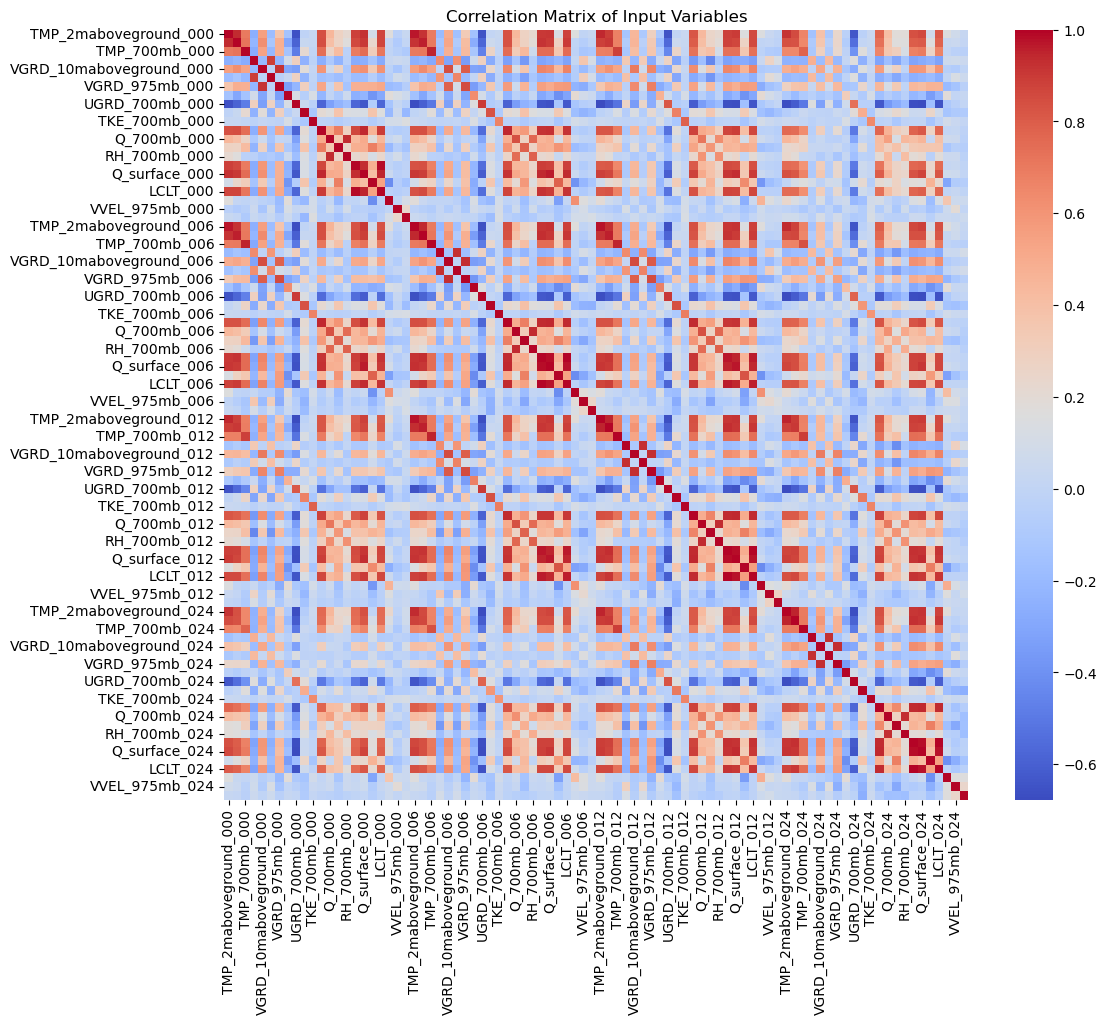

In [10]:
# Select columns from the 3rd to the last
selected_columns = dataset.iloc[:, 3:]

# Compute the correlation matrix
correlation_matrix = selected_columns.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Input Variables')
plt.show()

In [11]:
def split_dataframe_by_date(df, time_col, date_ranges):
    """
    Splits a DataFrame into multiple DataFrames based on specified date ranges.

    Args:
    df (pd.DataFrame): The original DataFrame.
    time_col (str): The name of the column containing time data.
    date_ranges (list of tuples): A list of tuples where each tuple contains start and end dates as strings.
                                  Example: [('2009-01-01', '2012-12-31'), ('2013-01-01', '2017-12-31')]

    Returns:
    list: A list containing the split DataFrames.
    """

    # Convert the time column to datetime
    df[time_col] = pd.to_datetime(df[time_col])

    # Initialize an empty list to store the split DataFrames
    split_dfs = []

    # Loop through the date ranges and split the DataFrame
    for start_date, end_date in date_ranges:
        split_df = df[(df[time_col] >= start_date) & (df[time_col] <= end_date)]
        split_dfs.append(split_df)

    # Handling the remaining data for dates beyond the last specified range
    if len(date_ranges) > 1:
        last_end_date = date_ranges[-1][1]
        remaining_df = df[df[time_col] > last_end_date]
        split_dfs.append(remaining_df)

    return split_dfs

# Example usage
date_ranges = [('2009-01-01', '2015-12-31'), ('2016-01-01', '2017-12-31')]
train_df, valid_df, test_df = split_dataframe_by_date(dataset, 'date_time', date_ranges)
print(f"train dataset samples: {train_df.shape[0]} | valid dataset samples: {valid_df.shape[0]} | test dataset samples: {test_df.shape[0]}")

train dataset samples: 6692 | valid dataset samples: 2092 | test dataset samples: 2228


In [12]:
train_df = train_df.reset_index()
valid_df = valid_df.reset_index()
test_df = test_df.reset_index()

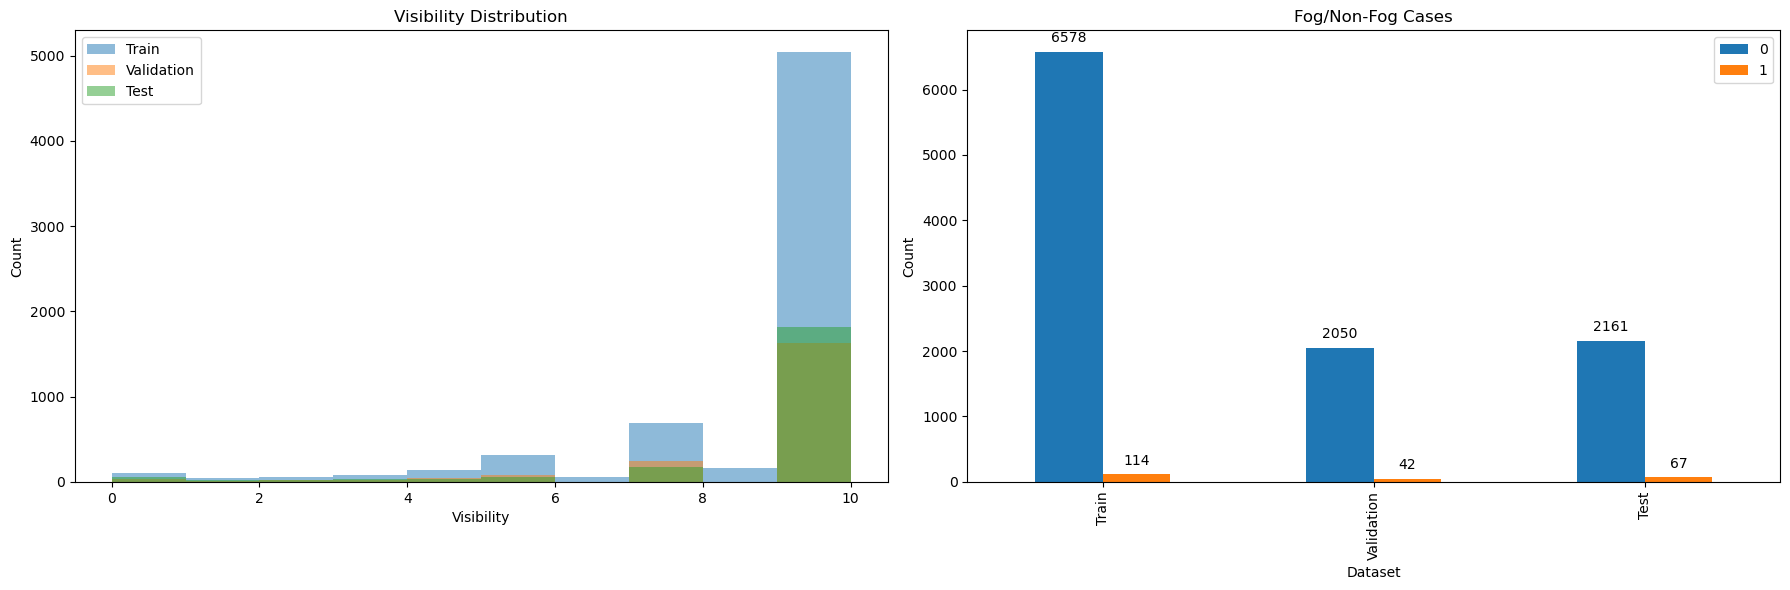

In [13]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plotting the bar plot for visibility distribution with 10 bins
bins = np.linspace(0, 10, 11)
ax1.hist(train_df['vis'], bins=bins, alpha=0.5, label='Train')
ax1.hist(valid_df['vis'], bins=bins, alpha=0.5, label='Validation')
ax1.hist(test_df['vis'], bins=bins, alpha=0.5, label='Test')
ax1.set_title('Visibility Distribution')
ax1.set_xlabel('Visibility')
ax1.set_ylabel('Count')
ax1.legend()

# Plotting the bar chart for fog/non-fog cases
fog_counts = [
    train_df['vis_class'].value_counts(),
    valid_df['vis_class'].value_counts(),
    test_df['vis_class'].value_counts()
]
fog_df = pd.DataFrame(fog_counts, index=['Train', 'Validation', 'Test'])
fog_df.plot(kind='bar', ax=ax2)

# Adding count annotations on the bars
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax2.set_title('Fog/Non-Fog Cases')
ax2.set_xlabel('Dataset')
ax2.set_ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()

In [19]:
class dataloader(): 

    def __init__(self, dataframe):

        self.dataframe = dataframe
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx): 

        input = self.dataframe.iloc[idx][3:]
        input = torch.as_tensor(input, dtype=torch.float32)

        label = self.dataframe.iloc[idx]['vis_class'] 
        label = torch.as_tensor(label) #, dtype= torch.long

        sample = {
            "input": input, 
            "label": label}

        return sample

In [20]:
train_dataset = dataloader(train_df)
valid_dataset = dataloader(valid_df)
test_dataset = dataloader(test_df)

In [21]:
data_loader_training = torch.utils.data.DataLoader(train_dataset, batch_size= 32, 
                                                shuffle = True,  num_workers=0) 
data_loader_validate = torch.utils.data.DataLoader(valid_dataset, batch_size= 32, 
                                                shuffle = False, num_workers=0) 
data_loader_testing  = torch.utils.data.DataLoader(test_dataset, batch_size= 32, 
                                                shuffle = False,  num_workers=0) 

#### Model

In [15]:
class Embedding1D(nn.Module):
    def __init__(self, ver_size, embed_size, dropout):
        """
        Initializes a custom embedding module to handle 1D data (e.g., time series or any non-textual numerical data).

        Args:
        ver_size (int): The size of the variable (number of unique tokens or bins).
        embed_size (int): The size of each embedding vector.
        dropout (float): Dropout rate for regularization.

        The module creates embeddings for discretized 1D data, adds positional embeddings, and includes a classification token ('cls_token').
        """
        super(Embedding1D, self).__init__()

        n_tokens = ver_size
        # Define an embedding layer. 
        # This maps the discretized data to an embedding space.
        self.embeddings = nn.Embedding(1000, embed_size)  # 1000 bins and 512 embedding size

        # Positional embeddings for maintaining the order of the input.
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_tokens + 1, embed_size))
        
        # A special token for classification tasks (similar to BERT's [CLS] token).
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_size))
        
        # Dropout layer for regularization.
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass of the Embedding1D module.

        Args:
        x (Tensor): Input tensor of shape (batch_size, sequence_length).

        Returns:
        Tensor: Output tensor after applying embeddings and adding positional information.
        """
        # Discretize the float data into integer indices.
        min_val = x.min()
        max_val = x.max()
        bins = np.linspace(min_val.item(), max_val.item(), 1000)

        # Convert the values to indices based on the defined bins.
        indices = np.digitize(x.cpu().numpy(), bins) - 1
        indices = torch.LongTensor(indices).to(device)

        # Apply the embedding layer.
        x = self.embeddings(indices)

        B = x.shape[0]
        # Expand the cls_token to match the batch size and concatenate it with the input.
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add the positional embeddings and apply dropout.
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)

        return embeddings


class Encoder1D(nn.Module):
    """
    The Encoder1D class is a custom encoder module designed for handling 1D data sequences. It's structured similarly to
    the encoder part of the Transformer architecture but is adapted for 1D data. The module uses a custom embedding layer
    for 1D data and a series of Transformer layers to process the sequence.
    """
    def __init__(
        self, 
        ver_size, 
        embed_size, 
        dropout,
        num_layers=4, 
        expansion_factor=4, 
        heads=8
    ) -> None:
        """
        Initializes the Encoder1D module.

        Args:
        ver_size (int): Size of the variable (number of unique tokens or bins).
        embed_size (int): Size of the embedding vectors.
        dropout (float): Dropout rate.
        num_layers (int): Number of Transformer layers in the encoder.
        expansion_factor (int): Expansion factor for the feed-forward network within the Transformer layers.
        heads (int): Number of heads in the multi-head attention mechanism.
        """
        super(Encoder1D, self).__init__()

        # Embedding layer specifically designed for 1D data.
        self.embedding_layer = Embedding1D(ver_size, embed_size, dropout)

        # Stack of Transformer layers.
        self.layers = nn.ModuleList(
            [
                TransformerLayer(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=expansion_factor,
                )
                for _ in range(num_layers)
            ]
        )

    def forward(self, x):
        """
        Forward pass through the encoder.

        Args:
        x (Tensor): Input tensor representing a sequence of 1D data.

        Returns:
        Tensor: Output tensor after processing through the embedding layer and Transformer layers.
        """
        # Process the input through the embedding layer.
        x = self.embedding_layer(x)

        # Pass the embedded input through each Transformer layer.
        for layer in self.layers:
            x = layer(x, x, x, None) # In the Encoder, the input serves as Q, K, V.

        return x
    

class Fog_Transformer(nn.Module):
    """
    The Fog_Transformer class is a neural network model designed for processing 1D data sequences, particularly aimed at
    tasks like fog prediction. It is based on the Transformer architecture, utilizing a custom 1D data encoder.
    """
    def __init__(self, ver_size, 
                 embed_size=512, 
                 dropout=0,
                 num_layers=6, 
                 forward_expansion=4, 
                 heads=8, 
                 num_class=2):
        """
        Initializes the Fog_Transformer model.

        Args:
        ver_size (int): Size of the variable (number of unique tokens or bins for 1D data).
        embed_size (int): Size of the embedding vectors.
        dropout (float): Dropout rate.
        num_layers (int): Number of layers in the encoder.
        forward_expansion (int): Expansion factor for the feed-forward network within the encoder layers.
        heads (int): Number of heads in the multi-head attention mechanism in the encoder.
        num_class (int): Number of output classes for the classification task.
        """
        super(Fog_Transformer, self).__init__()

        self.pool = None # Optional pooling strategy (e.g., 'mean' pooling)
        
        # Encoder module specifically designed for 1D data.
        self.encoder = Encoder1D(
            ver_size, 
            embed_size, 
            dropout,
            num_layers, 
            heads, 
            forward_expansion
        )
        
        # Classifier linear layer for the final output.
        self.classifier = nn.Linear(embed_size, num_class)

    def forward(self, x):
        """
        Forward pass through the Fog_Transformer model.

        Args:
        x (Tensor): Input tensor representing a sequence of 1D data.

        Returns:
        Tensor: Logits tensor after processing through the encoder and classifier. Shape: (batch_size, num_class).
        """
        # Process the input through the encoder.
        x = self.encoder(x)

        # Apply pooling strategy (mean pooling or taking the first element).
        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        # Pass through the classifier to get the final logits.
        logits = self.classifier(x)

        return logits


In [16]:
model = Fog_Transformer(
    ver_size = 89,
    embed_size = 512, 
    dropout = 0.3,
    num_layers = 6, 
    forward_expansion = 4, 
    heads = 8, 
    num_class = 2
    ).to(device)

In [17]:
optimizer = optim.AdamW(model.parameters(), 
                        lr=1e-3, 
                        weight_decay=1e-2)
loss_func  = torch.nn.BCEWithLogitsLoss()

In [22]:
best_val_loss = float('inf')  # Initialize to infinity for better practice
epochs = 30

for epoch in range(1, epochs + 1):
    training_start_time = time.time()

    # Initialize epoch losses
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0

    # Training Phase
    model.train()
    for sample in data_loader_training:
        xtrain = sample['input'].to(device).long()
        ytrain_true = sample['label'].to(device).float()

        optimizer.zero_grad()
        ytrain_pred = model(xtrain)
        train_loss = loss_func(ytrain_pred[:, 1], ytrain_true)
        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()

    # Validation Phase
    model.eval()
    with torch.no_grad():
        for sample in data_loader_validate:
            xvalid = sample['input'].to(device).float()
            yvalid_true = sample['label'].to(device).float()
            yvalid_pred = model(xvalid)

            val_loss = loss_func(yvalid_pred[:, 1], yvalid_true)
            val_epoch_loss += val_loss.item()

    # Calculate time taken for the epoch
    training_duration_time = time.time() - training_start_time

    # Compute average losses
    avg_train_loss = train_epoch_loss / len(data_loader_training)
    avg_val_loss = val_epoch_loss / len(data_loader_validate)

    # Print training stats
    print(f'Epoch {epoch:03}: | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time(s): {training_duration_time:.3f}') 

    # Model Saving Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), './best_model.pth')
        print(f'===================== Best model Saved! Val Loss: {best_val_loss:.4f} ====================')
    else:
        print(f'Model is not saved! Current Val Loss: {avg_val_loss:.4f}') 


Epoch 001: | Train Loss: 0.0979 | Val Loss: 0.0978 | Time(s): 46.811
===================== Best model Saved! Val Loss: 0.0978 ====================
Epoch 002: | Train Loss: 0.0892 | Val Loss: 0.1102 | Time(s): 48.212
Model is not saved! Current Val Loss: 0.1102
Epoch 003: | Train Loss: 0.0930 | Val Loss: 0.0976 | Time(s): 48.291
===================== Best model Saved! Val Loss: 0.0976 ====================
Epoch 004: | Train Loss: 0.0889 | Val Loss: 0.1007 | Time(s): 47.203
Model is not saved! Current Val Loss: 0.1007
Epoch 005: | Train Loss: 0.0906 | Val Loss: 0.0997 | Time(s): 47.274
Model is not saved! Current Val Loss: 0.0997
Epoch 006: | Train Loss: 0.0903 | Val Loss: 0.0986 | Time(s): 47.373
Model is not saved! Current Val Loss: 0.0986
Epoch 007: | Train Loss: 0.0893 | Val Loss: 0.0990 | Time(s): 47.487
Model is not saved! Current Val Loss: 0.0990
Epoch 008: | Train Loss: 0.0887 | Val Loss: 0.0985 | Time(s): 47.222
Model is not saved! Current Val Loss: 0.0985
Epoch 009: | Train Los

#### Exercise 1: Evaluation the Model

#### Exercise 2: High Temp Prediction

In [ ]:
total_dataset = pd.read_csv('../data/kdfw_processed_data.csv',index_col=0).sort_values(by='date') ##kdfw - Dallas-Ft Worth, TX
total_dataset = total_dataset.replace('********', np.nan).replace(np.inf, np.nan).dropna(how='any',axis=1)
total_dataset.head(5)

In [22]:
#Observation data
total_label_data = total_dataset.filter(like='OBS')

#remove obs data and date from the feature set
dropCols = list(total_label_data.columns) # + ['date']
total_feature_data = total_dataset.copy(deep=True)
total_feature_data = total_feature_data.drop(dropCols,axis=1)

subsample_feature = total_feature_data.iloc[:,:51] #date + 50 features

subsample_label = total_label_data['OBS_tmpf_max'][:]

In [23]:
subsample_label_class = pd.DataFrame()
subsample_label_class['class'] = np.where(subsample_label > 100, 1, 0)
# Binarize the 'temperature' column and label classes
subsample_label_class['class_name'] = np.where(subsample_label > 100, 'Severe Days', 'Common Days')

In [24]:
def split_data_by_date(features, labels, date_ranges):
    """
    Splits a DataFrame into multiple DataFrames based on specified date ranges.

    Args:
    df (pd.DataFrame): The original DataFrame.
    time_col (str): The name of the column containing time data.
    date_ranges (list of tuples): A list of tuples where each tuple contains start and end dates as strings.
                                  Example: [('2009-01-01', '2012-12-31'), ('2013-01-01', '2017-12-31')]

    Returns:
    list: A list containing the split DataFrames.
    """

    features_list = pd.to_datetime(features['date'])
    date_mask = (features_list > date_ranges[0]) & (features_list <= date_ranges[1])
    out_data = features.loc[date_mask,:].drop(['date'], axis=1)
    out_labels = labels.loc[date_mask]

    return out_data, out_labels

In [ ]:
date_ranges = [('2011-01-01','2017-12-31'), ('2018-01-01','2019-12-31')]
time_train_x, time_train_y = split_data_by_date(subsample_feature, subsample_label_class,  date_ranges[0])
time_test_x, time_test_y = split_data_by_date(subsample_feature, subsample_label_class, date_ranges[1])
print(f"train dataset samples: {time_train_x.shape} | test dataset samples: {time_test_x.shape}")

In [26]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(train_x, test_x):
    """
    Scales training and testing data using MinMaxScaler.

    Parameters:
    train_x (array-like): Training data features.
    test_x (array-like): Testing data features.

    Returns:
    tuple: Scaled training and testing data.
    """

    # Fit/find minimum and maximum value for each input variable
    min_max_model = MinMaxScaler().fit(train_x)

    # This saves the values to apply or 'transform' testing data
    train_x_minmax = min_max_model.transform(train_x)
    #print('Training data range \nMax:', np.nanmax(train_x_minmax), ', Min:', np.nanmin(train_x_minmax))

    # Apply the min/max values to testing data
    test_x_minmax = min_max_model.transform(test_x)
    #print('\nTesting data range \nMax:', np.nanmax(test_x_minmax), ', Min:', np.nanmin(test_x_minmax))

    return train_x_minmax, test_x_minmax

def split_data_by_date(features, labels, date_ranges):
    """
    Splits a DataFrame into multiple DataFrames based on specified date ranges.

    Args:
    df (pd.DataFrame): The original DataFrame.
    time_col (str): The name of the column containing time data.
    date_ranges (list of tuples): A list of tuples where each tuple contains start and end dates as strings.
                                  Example: [('2009-01-01', '2012-12-31'), ('2013-01-01', '2017-12-31')]

    Returns:
    list: A list containing the split DataFrames.
    """

    features_list = pd.to_datetime(features['date'])
    date_mask = (features_list > date_ranges[0]) & (features_list <= date_ranges[1])
    out_data = features.loc[date_mask,:].drop(['date'], axis=1)
    out_labels = labels.loc[date_mask]

    return out_data, out_labels

In [27]:
scaled_time_train_x, scaled_time_test_x = scale_data(time_train_x, time_test_x)

In [ ]:
train_df = pd.DataFrame()
train_df['label'] = time_train_y['class'].values
new_rows = pd.DataFrame(scaled_time_train_x)
train_df = pd.concat((train_df, new_rows), axis = 1)
train_df

In [ ]:
test_df = pd.DataFrame()
test_df['label'] = time_test_y['class'].values
new_rows_test = pd.DataFrame(scaled_time_test_x)
test_df = pd.concat((test_df, new_rows_test), axis = 1)
test_df

In [31]:
class dataloader(): 

    def __init__(self, dataframe):

        self.dataframe = dataframe
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx): 

        input = self.dataframe.iloc[idx][1:]
        input = torch.as_tensor(input, dtype=torch.float32)

        label = self.dataframe.iloc[idx]['label'] 
        label = torch.as_tensor(label) #, dtype= torch.long

        sample = {
            "input": input, 
            "label": label}

        return sample

In [32]:
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [33]:
train_dataset = dataloader(train_df)
test_dataset = dataloader(test_df)

In [34]:
data_loader_training = torch.utils.data.DataLoader(train_dataset, batch_size= 32, 
                                                shuffle = True,  num_workers=0) 
data_loader_testing  = torch.utils.data.DataLoader(test_dataset, batch_size= 32, 
                                                shuffle = False,  num_workers=0) 

In [ ]:
best_val_loss = float('inf')  # Initialize to infinity for better practice
epochs = 30

for epoch in range(1, epochs + 1):
    training_start_time = time.time()

    # Initialize epoch losses
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0

    # Training Phase
    model.train()
    for sample in data_loader_training:
        xtrain = sample['input'].to(device).float()
        ytrain_true = sample['label'].to(device).float()


        optimizer.zero_grad()
        ytrain_pred = model(xtrain)
        train_loss = loss_func(ytrain_pred[:, 1], ytrain_true)
        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()

    # Validation Phase
    model.eval() 
    with torch.no_grad():
        for sample in data_loader_testing:
            xvalid = sample['input'].to(device).float()
            yvalid_true = sample['label'].to(device).float()
            yvalid_pred = model(xvalid)

            val_loss = loss_func(yvalid_pred[:, 1], yvalid_true)
            val_epoch_loss += val_loss.item()

    # Calculate time taken for the epoch
    training_duration_time = time.time() - training_start_time

    # Compute average losses
    avg_train_loss = train_epoch_loss / len(data_loader_training)
    avg_val_loss = val_epoch_loss / len(data_loader_validate)

    # Print training stats
    print(f'Epoch {epoch:03}: | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time(s): {training_duration_time:.3f}') 

    # Model Saving Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), './best_model.pth')
        print(f'===================== Best model Saved! Val Loss: {best_val_loss:.4f} ====================')
    else:
        print(f'Model is not saved! Current Val Loss: {avg_val_loss:.4f}') 
